In [178]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

In [238]:
df = pd.read_csv('MICRODADOS_ENEM_2023.csv', sep=';', encoding='latin-1')

Estrutura do DataFrame

In [239]:
df

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,210059085136,2023,14,M,2,1,1,1,17,1,...,C,C,B,B,A,B,B,A,A,B
1,210059527735,2023,12,M,2,1,0,1,16,1,...,B,A,B,B,A,A,C,A,D,B
2,210061103945,2023,6,F,1,1,1,1,0,1,...,B,A,A,B,A,A,A,A,A,B
3,210060214087,2023,2,F,1,3,1,2,0,2,...,A,A,A,B,A,A,D,A,A,B
4,210059980948,2023,3,F,1,3,1,2,0,2,...,A,A,A,B,A,A,B,A,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98430,210058608817,2023,3,F,1,3,1,1,2,1,...,A,A,A,B,A,A,C,A,A,B
98431,210059316728,2023,2,F,1,2,1,2,0,2,...,A,A,A,B,A,A,B,B,A,B
98432,210060389142,2023,7,F,1,1,1,1,4,1,...,A,A,A,C,A,B,D,B,C,B
98433,210061276034,2023,5,F,1,4,1,1,3,1,...,A,A,B,B,A,A,D,A,A,B


Larga colunas que não são importantes para a análise.

In [240]:
df.drop(['NU_INSCRICAO', 'NU_ANO', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH',
         'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC', 'TX_GABARITO_MT', 'CO_MUNICIPIO_ESC'], # O código do município pode ser descartado pois há também uma coluna com o nome do município
         axis=1, inplace=True)

*   A coluna TP_DEPENDENCIA_ADM_ESC indica se a escola é Privada, Federal, Estadual ou Municipal.
*   A coluna NU_NOTA_REDACAO e NU_NOTA_MT indicam a nota da redação e da prova de matemática do aluno.
*   A coluna TP_ENSINO indica o tipo de instituição que o aluno concluiu o ensino médio (normal ou supletivo).

Estas colunas contém informações bem importantes para a classificação, mas estão com vários valores nulos. Como não dá para preencher estes valores com por exemplo a média da coluna, estas linhas serão desconsideradas.

In [241]:
df.dropna(subset=['TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_REDACAO', 'NU_NOTA_MT', 'TP_ENSINO'], inplace=True)

Não restam valores nulos nas demais colunas.

In [242]:
sum( df.isna().sum() )

0

Aplica o One-Hot Encoding nas colunas categóricas.

In [244]:
df = pd.get_dummies(df, drop_first=True,
                    columns=['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
                             'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
                             'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA',
                             'CO_UF_PROVA', 'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_LINGUA',
                             'TP_STATUS_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012',
                             'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025'])

Categorização das médias, onde a classe i conterá as notas no intevalo [ i×100, (i+1)×100 )


*   Classe 0: [  0, 100)
*   Classe 1: [100, 200)
*   Classe 2: [200, 300) ...



In [245]:
# Cálculo das médias
medias = (df['NU_NOTA_CH'] + df['NU_NOTA_LC'] +
          df['NU_NOTA_MT'] + df['NU_NOTA_CN'] +
          df['NU_NOTA_REDACAO']) / 5
# Intervalos das médias
intervalos = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# Classifica a média em classes de 0 a 9
df['MÉDIA_CLASSES'] = pd.cut(medias, bins=intervalos, labels=range(10), right=False).astype(int)

Larga as colunas relacionadas a média, já que estão diretamente relacionadas à média.

In [246]:
df.drop(['NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_REDACAO',
         'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5'], axis=1, inplace=True)

Nova Estrutura do DataFrame.

In [247]:
df

,TP_FAIXA_ETARIA_2,TP_FAIXA_ETARIA_3,TP_FAIXA_ETARIA_4,TP_FAIXA_ETARIA_5,TP_FAIXA_ETARIA_6,TP_FAIXA_ETARIA_7,TP_FAIXA_ETARIA_8,TP_FAIXA_ETARIA_9,TP_FAIXA_ETARIA_10,TP_FAIXA_ETARIA_11,...,Q022_C,Q022_D,Q022_E,Q023_B,Q024_B,Q024_C,Q024_D,Q024_E,Q025_B,MÉDIA_CLASSES
3,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,5
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4
11,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,6
16,False,False,True,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,5
41,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98417,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,4
98418,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4
98419,False,True,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,True,True,5
98421,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,6


Definindo a coluna alvo.

In [248]:
X = df.drop('MÉDIA_CLASSES', axis=1)
y = df['MÉDIA_CLASSES']

Separação dos dados em teste e treino.

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

Treino do modelo.

In [250]:
model = AdaBoostClassifier(random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00       242
           4       0.00      0.00      0.00      1338
           5       0.44      0.83      0.58      2392
           6       0.47      0.40      0.43      1521
           7       0.00      0.00      0.00       280
           8       0.00      0.00      0.00         4

    accuracy                           0.45      5811
   macro avg       0.10      0.14      0.11      5811
weighted avg       0.31      0.45      0.35      5811



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A precisão do modelo foi 0 na maioria das categorias, exceto nas 5 e 6, as duas classes com maior quantidade de valores, onde obteve um resultado moderado.

Análise das variáveis mais importantes

In [251]:
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False).head(5)

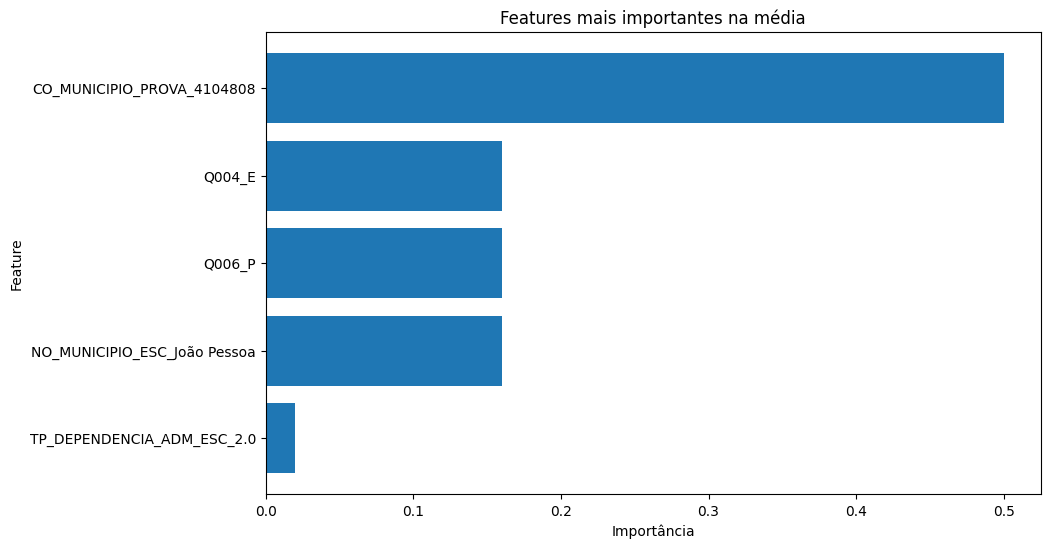

In [252]:
plt.figure(figsize=(10, 6))
plt.barh(importances['feature'], importances['importance'])
plt.title('Features mais importantes na média')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

As 5 features mais importantes no acerto da classe da média são:
1.   CO_MUNICIPIO_PROVA_4104808 : Candidato realizou a prova na cidade de Cascavel-Paraná.
2.   Q006_P : Candidato com renda mensal de R\$ 19.800,01 até R\$ 26.400,00.
3.   Q004_E : Profissão da mãe do candidato entre as seguintes: Médica, engenheira, dentista, psicóloga, economista, advogada, juíza, promotora, defensora, delegada, tenente, capitã, coronel, professora universitária, diretora em empresas públicas ou privadas, política, proprietária de empresas com mais de 10 empregados.
4.   NO_MUNICIPIO_ESC_2507507.0 : Candidato residente na cidade de João Pessoa
5.   TP_DEPENDENCIA_ADM_ESC_2.0 : Candidato de escola Estadual.
